In [2]:
from transformers import ESMForMaskedLM, ESMTokenizer, pipeline
#https://discuss.huggingface.co/t/solved-model-esm-1b-is-not-defined/17104
import pandas as pd
import numpy as np
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import torch
import math
import utilities

/Users/daniel/miniconda3/envs/nlp/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [3]:
alphabet.tok_to_idx

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

In [4]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [5]:
# mask amino acid, take BCE loss of softmax(predicted) from actual, average for all amino acid of same type, compare across
aa_loss = {}
aa_counts = {}
for i in range(1):
    seq = fastas[seqids[i]]["sequence"]
    seq_list = utilities.mask_seq(seq)
    #for temp_seq in seq_list:
    #get all logit for entire sequence
    results = None
    for i in range(0, len(seq_list), 10):
        temp_result = utilities.forward_pass(model, alphabet, seq_list[i:i+10])
        if results == None:
            results = temp_result
        else:
            results = torch.concat((results, temp_result), dim=0)
        print(results.shape)
        if i == 10: break
    #print(results)
    # go through, subset to just maxed amino acid, softmax of predicted layer, BCE with real
    for j, result in enumerate(results):
        masked_aa = seq[j]
        correct_row = result[j+1]
        softmax = torch.nn.Softmax(dim=-1)
        soft_row = softmax(correct_row)
        bce = torch.nn.CrossEntropyLoss()
        target = torch.tensor([alphabet.tok_to_idx[masked_aa]])
        loss = bce(torch.reshape(soft_row, (1,33)), target)
        try:
            aa_loss[masked_aa] += float(loss)
        except KeyError:
            aa_loss[masked_aa] = float(loss)
        
        try:
            aa_counts[masked_aa] += 1
        except KeyError:
            aa_counts[masked_aa] = 1
    #print(results)



torch.Size([10, 258, 33])
torch.Size([20, 258, 33])


In [10]:
np.array(list(aa_loss.values()))/np.array(list(aa_counts.values()))

array([3.04335737, 3.44195708, 3.5010016 , 3.35975695, 3.37050001,
       3.44675767, 3.4273653 , 3.41229892, 3.38035178, 3.49524617,
       3.43285882])

In [7]:
aa_counts

{'M': 2,
 'A': 3,
 'F': 1,
 'S': 1,
 'E': 3,
 'D': 2,
 'V': 1,
 'L': 1,
 'K': 1,
 'Y': 1,
 'R': 4}

In [8]:
results[0].shape

torch.Size([258, 33])

In [11]:
[("blah", x) for x in seq_list][0]

'<mask>AFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQVECPKAPVEWNNPPSEKGLIVGHFSGIKYKGEKAQASEVDVNKMCCWVSKFKDAMRRYQGIQTCKIPGKVLSDLDAKIKAYNLTVEGVEGFVRYSRVTKQHVAAFLKELRHSKQYENVNLIHYILTDKRVDIQHLEKDLVKDFKALVESAHRMRQGHMINVKYILYQLLKKHGHGPDGPDILTVKTGSKGVLYDDSFRKIYTDLGWKFTPL'

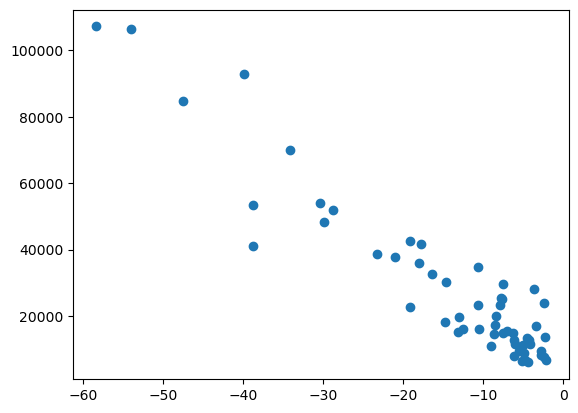

In [41]:
plt.scatter(seq_probs, analysis[0:56,0])

In [30]:
seq_length = np.array(seq_length)

In [66]:
seq_probs = np.array(seq_probs)
seq_probs_norm = seq_probs / np.floor(seq_length/20)[0:56]

TypeError: unsupported operand type(s) for /: 'list' and 'int'

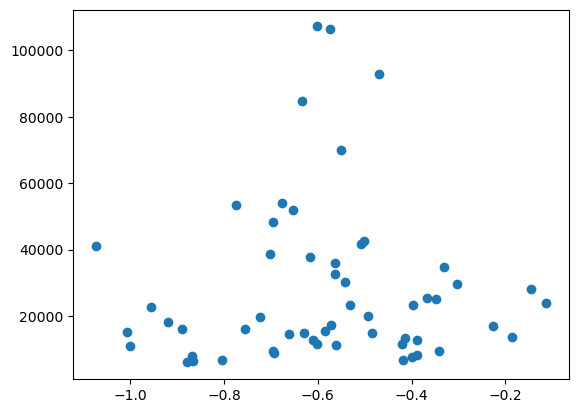

In [43]:
plt.scatter(seq_probs_norm, analysis[0:56,0])

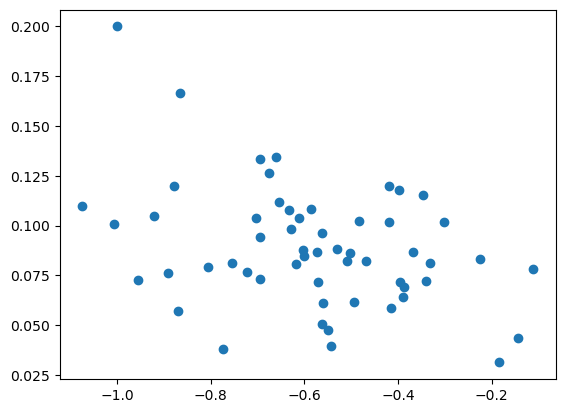

In [49]:
#aromaticity
plt.scatter(seq_probs_norm, analysis[0:56,3])

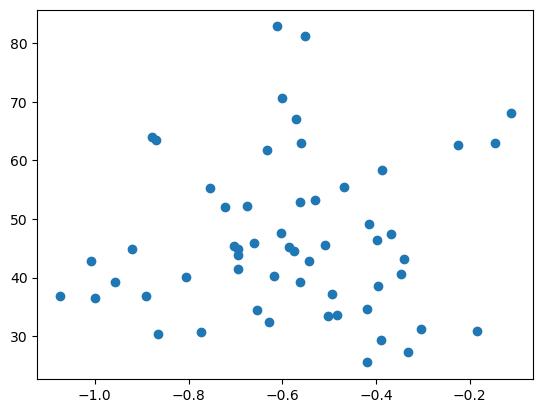

In [53]:
plt.scatter(seq_probs_norm, analysis[0:56,5])